This notebook loads a trained VAE and examines the reconstructions. 

To obtain the models displayed in this notebook, see the `../scripts/` folder, that contain the scripts used to generate these models. 

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

import sys
sys.path.insert(0, '../')

import mnist_data_lib
import mnist_vae_lib
import vae_utils

import semisuper_vae_training_lib as ss_lib

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Load data

In [2]:
seed = 901

In [3]:
?mnist_data_lib.get_mnist_dataset_semisupervised

In [4]:
np.random.seed(seed)
_ = torch.manual_seed(seed)

# LOAD DATA
train_set_labeled, train_set_unlabeled, test_set = \
    mnist_data_lib.get_mnist_dataset_semisupervised(data_dir = '../mnist_data/', 
                                                   train_test_split_folder = '../test_train_splits/')

number labeled:  5000
number unlabeled:  45000
evaluating on validation set. 


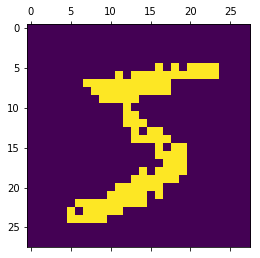

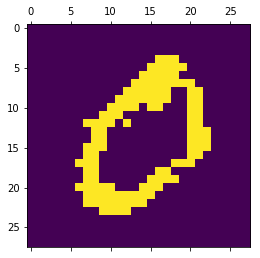

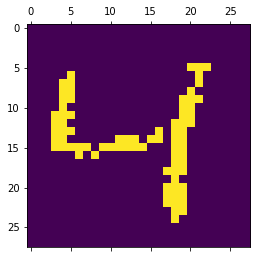

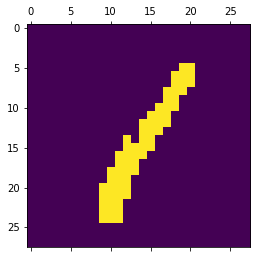

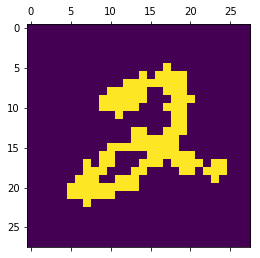

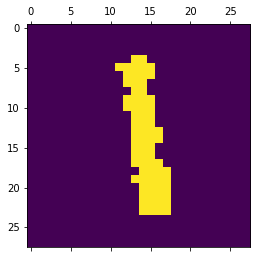

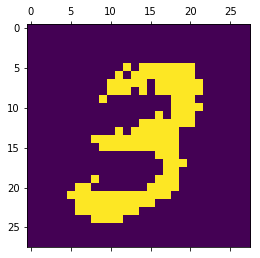

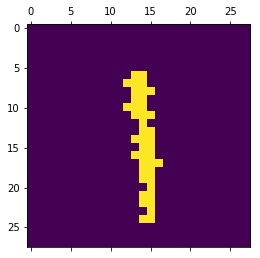

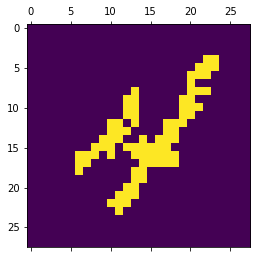

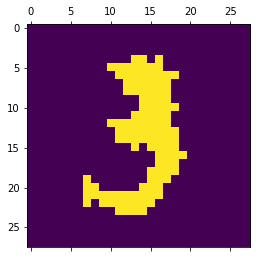

In [5]:
for i in range(10): 
    plt.matshow(train_set_unlabeled[i]['image'].squeeze())
    assert np.all(train_set_unlabeled[i]['image'].detach().numpy() <= 1)
    assert np.all(train_set_unlabeled[i]['image'].detach().numpy() >= 0)

In [6]:
batchsize = 50

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=batchsize,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [7]:
for batch_idx, d in enumerate(train_loader_labeled):
    labeled_data = d
    break
    
for batch_idx, d in enumerate(train_loader_unlabeled):
    unlabeled_data = d
    break
    
for batch_idx, d in enumerate(test_loader):
    test_data = d
    break


# Define VAE

In [8]:
latent_dim = 8
n_classes = 10
slen = train_set_unlabeled[0]['image'].shape[0]

In [9]:
vae, classifier = mnist_vae_lib.get_mnist_vae_and_classifier(latent_dim = latent_dim, 
                                                                n_classes = n_classes, 
                                                               slen = slen)

In [10]:
# Load results

file_base = '../mnist_vae_results/ss_vae_reinforce_topk1_trial10'
classifier_file = file_base + '_classifier_final'
vae_file = file_base + '_vae_final'

vae.load_state_dict(torch.load(vae_file,
                               map_location=lambda storage, loc: storage))

classifier.load_state_dict(torch.load(classifier_file,
                               map_location=lambda storage, loc: storage))


vae.eval();
classifier.eval();

# Check losses

In [11]:
batch_losses = np.load(file_base + '_batch_losses.npy')

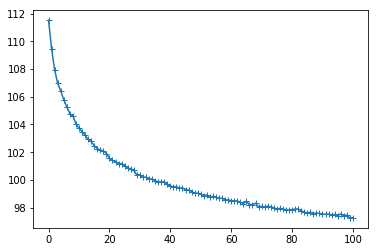

In [12]:
# plot losses
plt.plot(batch_losses, '+-')

In [13]:
train_losses = np.load(file_base + '_train_losses.npy')
test_losses = np.load(file_base + '_test_losses.npy')

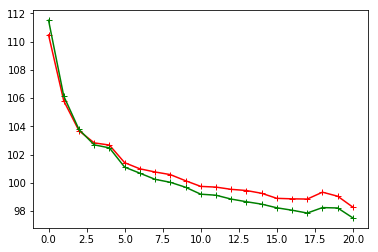

In [14]:
plt.plot(test_losses, 'r-+')
plt.plot(train_losses, 'g-+')

In [15]:
train_accuracies = np.load(file_base + '_train_accuracy.npy')
test_accuracies = np.load(file_base + '_test_accuracy.npy')

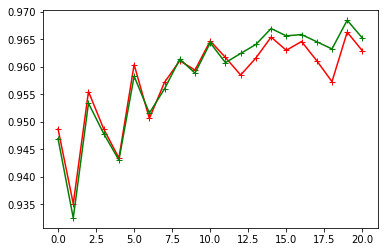

In [16]:
plt.plot(test_accuracies, 'r-+')
plt.plot(train_accuracies, 'g-+')

In [17]:
test_accuracies[-1]

0.9629

In [18]:
image = labeled_data['image']
log_q = classifier(image)
z = torch.argmax(log_q, dim = 1)

In [19]:
torch.max(torch.exp(log_q), dim = 1)

(tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        grad_fn=<MaxBackward0>),
 tensor([4, 4, 9, 5, 2, 7, 8, 0, 0, 6, 8, 2, 2, 6, 6, 8, 2, 3, 0, 5, 7, 0, 5, 9,
         3, 4, 2, 6, 7, 6, 1, 0, 4, 1, 5, 2, 0, 1, 5, 4, 1, 7, 2, 4, 9, 5, 7, 3,
         8, 4]))

In [20]:
loss = vae_utils.get_labeled_loss(vae, image, z).mean()

In [21]:
loss

tensor(98.1680, grad_fn=<MeanBackward1>)

In [22]:
batch_losses[-1]

97.27914

# Check reconstructions

In [23]:
one_hot_z = vae_utils.get_one_hot_encoding_from_int(z, n_classes)

In [24]:
latent_means, latent_std, latent_samples, image_mean = \
    vae.forward(image, one_hot_z)

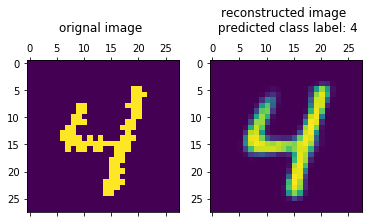

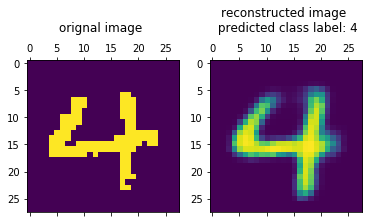

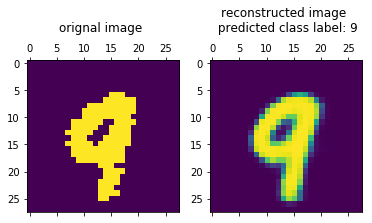

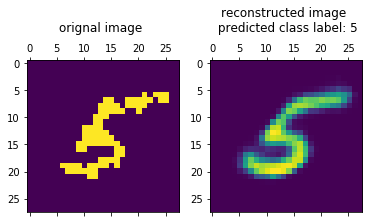

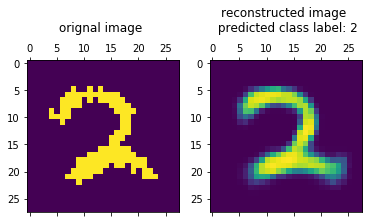

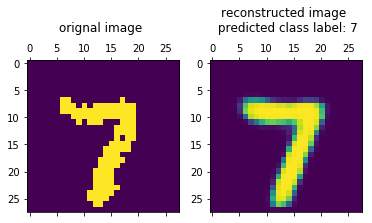

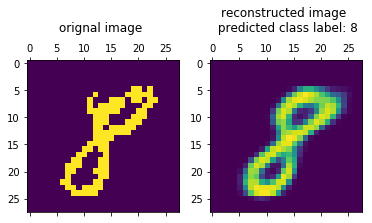

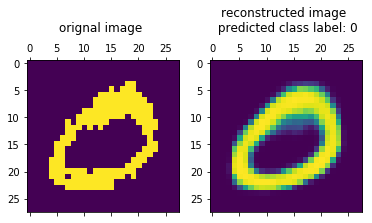

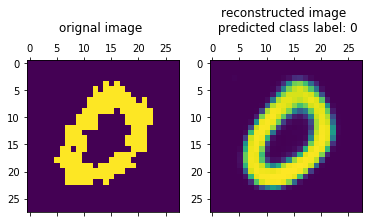

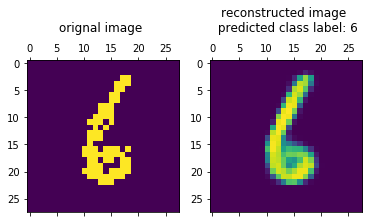

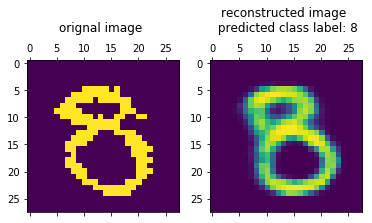

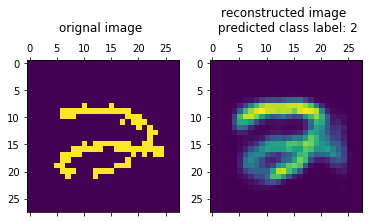

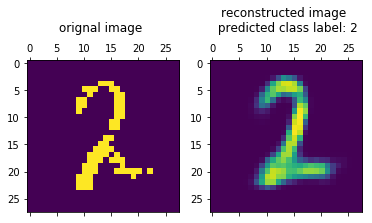

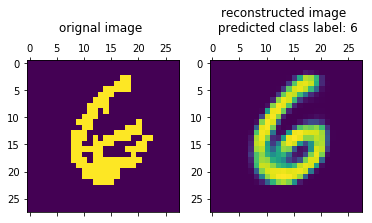

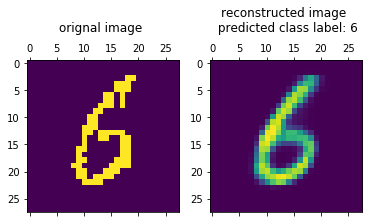

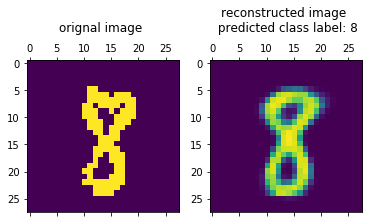

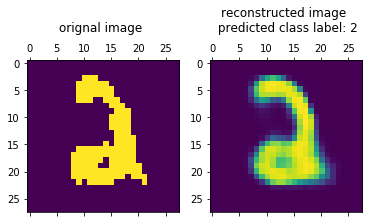

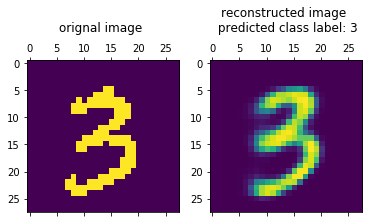

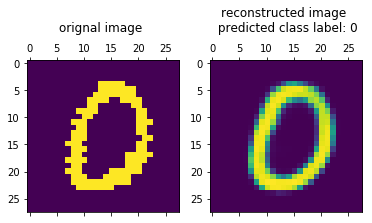

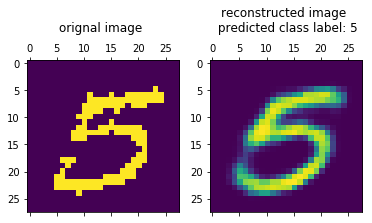

In [25]:
figsize = 6
for i in range(0, 20): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(image[i, :, :])
    axarr[1].matshow(image_mean[i, :, :].detach())
    
    axarr[0].set_title('orignal image \n')
    axarr[1].set_title('reconstructed image \n predicted class label: {}\n'.format(z[i]))

# check conditional generation

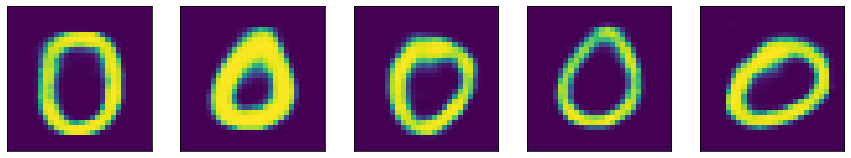

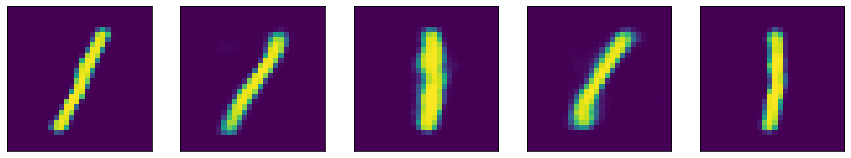

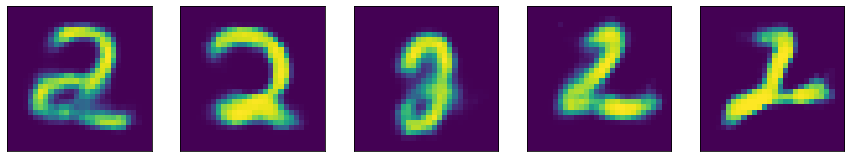

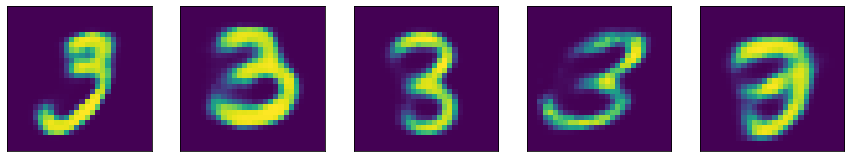

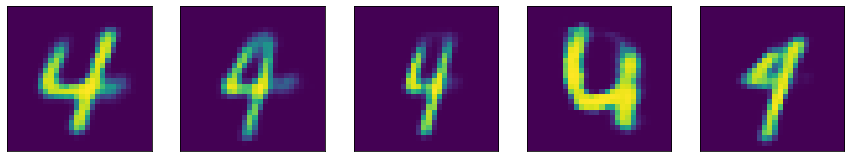

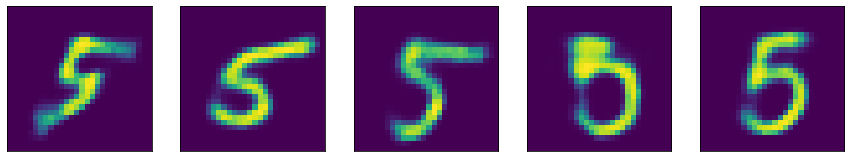

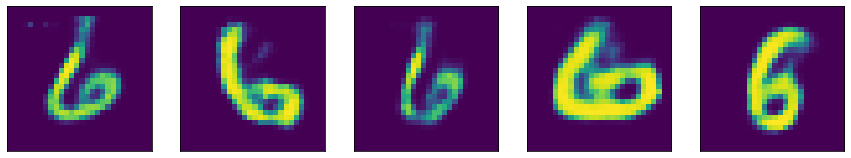

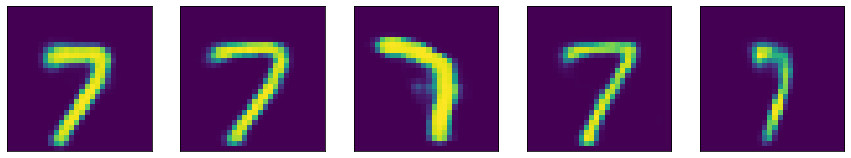

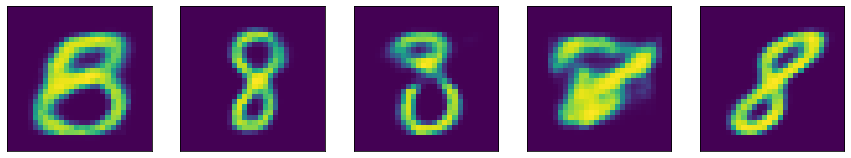

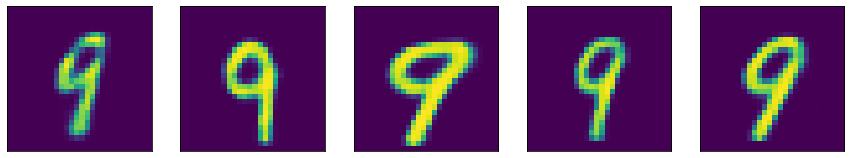

In [26]:
for i in range(10): 
    num = 5
    latent_params = torch.randn((5, latent_dim)) 

    digit = i
    one_hot_z = vae_utils.get_one_hot_encoding_from_int((torch.ones(num) * digit).type(torch.LongTensor), 
                                                        n_classes)
    recon_mean = vae.decoder(latent_params, one_hot_z)

    f, axarr = plt.subplots(1, num, figsize=(15, 15))

    for i in range(0, num): 
        axarr[i].matshow(recon_mean[i, :, :].detach())
        axarr[i].get_xaxis().set_visible(False)
        axarr[i].get_yaxis().set_visible(False)

